In [21]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt

### Load model

In [22]:
undamped_path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/overdamped_k14"
undamped_name = "model_overdamped_k14.pth"
undamped_model, training_log = model.load_model(undamped_path, undamped_name)

14 True False False [128, 128, 256]


### Problem definition

In [23]:
N = 5120
t_span = (0, 25)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [24]:
H_dict = transfer.compute_H_dict(undamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [25]:
w_list_transfer = [1, 1, 1, 1, 1]
zeta_list = [5, 10, 30, 40, 60]

#forcing_freq = [[1]]
#forcing_coef = [[1]]

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.cos(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.cos(t)), axis=1)
    return force


forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

forcing_1D = lambda t: np.cos(t)
ic_list = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
epsilon_list = [0.5, 0.5, 0.5, 0.5, 0.5]
p_list = [15]
q = 3

### Numerical solver

In [26]:
numerical_undamped_duffing_list = []

for zeta in zeta_list:
    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta, forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
    numerical_undamped_duffing_list.append(numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0]))

### PINN

In [27]:
NN_TL_solution, perturbation_solution, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution = NN_TL_solution.squeeze()

In [28]:
NN_TL_solution.shape

(5120, 5, 2)

zeta: 5, mean Error: 1.023e-04
zeta: 10, mean Error: 2.401e-04
zeta: 30, mean Error: 1.377e-04
zeta: 40, mean Error: 9.369e-05
zeta: 60, mean Error: 6.456e-05


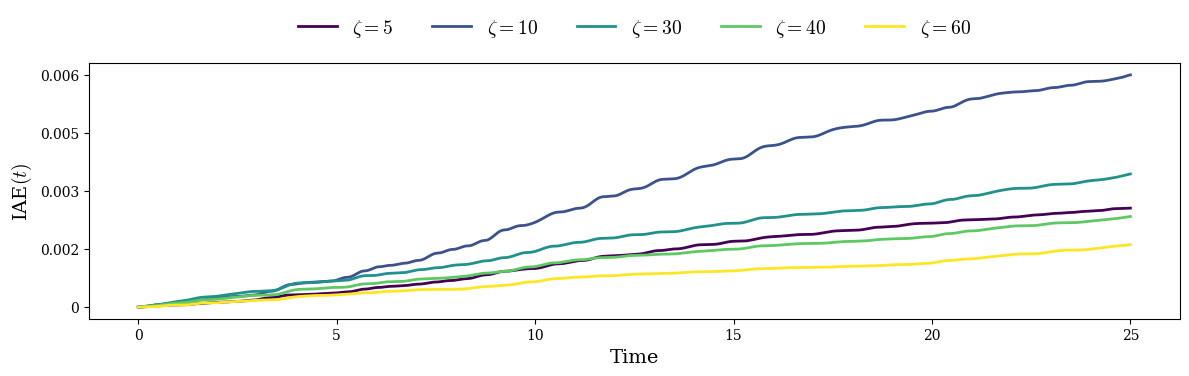

In [29]:
standard.plot_IAE_multiple_zeta(zeta_list, t_eval, NN_TL_solution, numerical_undamped_duffing_list)